# Contributors
Yap Shen Hwei (U2140630E): Training the Reinforcement Learning Agent 

Eddy Cheng Kuan Quan (U2121953D): Making observations 

Google Colab Link: https://colab.research.google.com/drive/1FAOT8gpGXbndATAiux5qBl9pq-TGgMe9?usp=sharing

The video doesn't seem to be rendering on Jupyter notebook, but shows on Google Colab, I had also attached a copy of the video on email. 

Thank you. 

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.04286386 -0.03231818  0.00830536 -0.04774256]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.04351023 -0.22755824  0.00735051  0.24754916]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

Codes have been **taken inspiration from the book**: Python Reinforcement Learning Projects [1]. 

**Originality of code:** We declare that we have typed all these codes out by ourselves, and have understood each step clearly, and demonstrated our understanding through giving explanations for each step and observation. 

**Definitions:**
- Exploration Rate: controls the probability that the agent will explore instead of exploit. 

- Learning Rate: controls how much to change the model in response to the estimated error each time the model weights are updated. [2]



In [ ]:
# initializing configurations 
no_buckets = (30, 30, 50, 50) #indicates the levels of discretization for (cart pos, cart velocity, pole angle, pole angular velocity)
no_actions = env.action_space.n #number of actions in the action space 
state_value_bounds = list(zip(env.observation_space.low, env.observation_space.high)) #gets the list of ranges [(cartposlow, cartposhigh), (cartvlow, cartvhigh),...]
state_value_bounds[1] = [-0.5, 0.5] #setting a limit for cart velocity, instead of -Inf to Inf 
state_value_bounds[3] = [-math.radians(50), math.radians(50)] #setting a limit for pole angular velocity, instead of -Inf and Inf 
action_index = len(no_buckets) 
q_value_table = np.zeros(no_buckets + (no_actions,)) #initialize q table, where shape of the table can be visualised as below
discount = 0.9 #gamma 
min_explore_rate = 0.1 #the minimum exploration rate - used when randomizing the exploration rate in each episode.
min_learning_rate = 0.4 #alpha in the equation 

<img src="https://drive.google.com/uc?export=view&id=1WMwwbL-49-xgk49o2zcbVpW4uwmlbE9e" width="300">


In [ ]:
def select_action(state_value, explore_rate):
  """
    function to select an action, the agent can either explore or exploit. 
  """
  if random.random() < explore_rate:
    action = env.action_space.sample() #explore 
  else: 
    action = np.argmax(q_value_table[state_value]) #exploit 
  return action 

In [ ]:
def select_explore_rate(x, min_explore_rate=min_explore_rate):
  """
  x : episode number 
  returns the explore rate 
  """
  return max(min_explore_rate, min(1, 1.0-math.log10((x+1)/25)))

In [ ]:
def select_learning_rate(x, min_learning_rate=min_learning_rate):
  """
  x : episode number 
  returns the learning rate 
  """
  return max(min_learning_rate, min(1, 1.0-math.log10((x+1)/25)))

In [ ]:
def bucketize_state_value(state_value):
  """
  this function discretizes each state based on the no_buckets and state_value_bounds specified earlier, and returns the discretized state. 

  """
  bucket_indexes = [] 
  for i in range(len(state_value)):
    if state_value[i] <= state_value_bounds[i][0]:
      bucket_index = 0 
    elif state_value[i] >= state_value_bounds[i][1]:
      bucket_index = no_buckets[i]-1
    else: 
      bound_width = state_value_bounds[i][1] - state_value_bounds[i][0] 
      offset = (no_buckets[i]-1)*state_value_bounds[i][0]/bound_width
      scaling = (no_buckets[i]-1)/bound_width 
      bucket_index = int(round(scaling*state_value[i] - offset))
    bucket_indexes.append(bucket_index)
  return tuple(bucket_indexes)

When training the agent, here are a few things to note: 
- The exploration rate is likely to decrease as episode no. increases, this method is known as annealing, to optimize the learning [3]. 
- Similarly for the learning rate. 
- These are reflected in the functions: select_learning_rate and select_explore_rate, where episode number is taken into account.

Each episode stops when completed = True only under the following conditions:
1. Pole angle greater than +-12 deg 
2. Cart pos greater than +-2.4 
3. Episode length is greater than 500 

Reward = +1 for every step taken 



Idea of Q learning algorithm: 

1. For each step of episode, choose an action A using epsilon greedy policy, derived from Q.
2. Take action A, observe R, S' (Reward and Next State) 
3. Q(S,A) <- Q(S,A) + learning_rate [R + gamma(max_aQ(S',a)) - Q(S,A)]

In [ ]:
# training the agent 
for episode_no in range(60000):
  explore_rate = select_explore_rate(episode_no) #select explore rate with annealling and randomization 
  learning_rate = select_learning_rate(episode_no) #select learning rate with annealling and randomization 

  observation = env.reset() #reset the initial state 
  start_state = bucketize_state_value(observation) #discretize/ bucketize the state value
  prev_state = start_state 

  total_reward = 0 
  completed = False 
  while not completed: #loop until the episode ends based on the terminating conditions aforementioned. 
    selected_action = select_action(prev_state, explore_rate) #select an action based on the explore rate, explore/ exploit. 
    observation, reward_gain, completed, _ = env.step(selected_action)
    state_value = bucketize_state_value(observation)
    best_q_value =np.amax(q_value_table[state_value]) # max_a Q(S', a)
    q_value_table[prev_state + (selected_action,)] += learning_rate * (reward_gain + discount * best_q_value - q_value_table[prev_state + (selected_action, )]) # q learning equation 
    total_reward += reward_gain
    prev_state = state_value 

  if episode_no%2000==0:
      print("Episode: "+str(episode_no)+", Reward: "+ str(total_reward))


Episode: 0, Reward: 42.0
Episode: 2000, Reward: 10.0
Episode: 4000, Reward: 9.0
Episode: 6000, Reward: 17.0
Episode: 8000, Reward: 12.0
Episode: 10000, Reward: 17.0
Episode: 12000, Reward: 10.0
Episode: 14000, Reward: 19.0
Episode: 16000, Reward: 12.0
Episode: 18000, Reward: 119.0
Episode: 20000, Reward: 302.0
Episode: 22000, Reward: 18.0
Episode: 24000, Reward: 372.0
Episode: 26000, Reward: 26.0
Episode: 28000, Reward: 210.0
Episode: 30000, Reward: 364.0
Episode: 32000, Reward: 54.0
Episode: 34000, Reward: 500.0
Episode: 36000, Reward: 38.0
Episode: 38000, Reward: 191.0
Episode: 40000, Reward: 157.0
Episode: 42000, Reward: 500.0
Episode: 44000, Reward: 484.0
Episode: 46000, Reward: 500.0
Episode: 48000, Reward: 218.0
Episode: 50000, Reward: 250.0
Episode: 52000, Reward: 144.0
Episode: 54000, Reward: 500.0
Episode: 56000, Reward: 500.0
Episode: 58000, Reward: 500.0


The agent is able to make the correct choices progressively, in general, at every 2000 episode. This is reflected at the trend of increasing rewards as episode number increases. The random dips are likely due to the stochastic nature of the environment.

For Task 1, we can show the observation and chosen action below:

In [ ]:
observation = env.reset()
action = np.argmax(q_value_table[current_state])
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.04683939 -0.00038736 -0.03608012  0.00129256]
Chosen action: 0


Action = 0 seems reasonable as the pole is currently tipping towards the left (-ve pole angle), so pushing the cart to the left will help the pole regain its balance. 

## Task 2: Demonstrate the effectiveness of the RL agent

In [ ]:
episode_results = np.zeros(100)
for i in range(100):
  current_state = bucketize_state_value(env.reset())
  cumulative_reward = 0
  done = False

  while not done:
    action = np.argmax(q_value_table[current_state])
    observation,reward,done,info = env.step(action)
    new_state = bucketize_state_value(observation)
    current_state = new_state
    cumulative_reward+=reward
  episode_results[i] = cumulative_reward

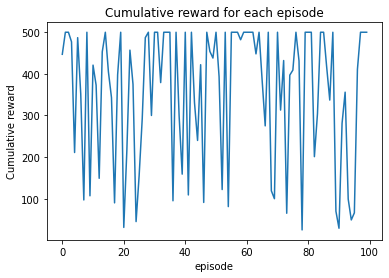

In [ ]:
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

The cumulative reward still fluctuates, but now, we reach a good enough learnt agent that. 

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 357.82
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = np.argmax(q_value_table[bucketize_state_value(observation)])
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()

# Task 4a: Observations


## A: The higher the number of episodes trained, the better the agent performs 

In [ ]:
def train_agent(epi_num, env=gym.make("CartPole-v1"), q_table=np.zeros(no_buckets + (no_actions,)), 
                min_learning_rate=min_learning_rate, min_explore_rate=min_explore_rate):
  for episode_no in range(epi_num):
    explore_rate = select_explore_rate(episode_no, min_explore_rate=min_explore_rate)
    learning_rate = select_learning_rate(episode_no, min_learning_rate=min_learning_rate)

    observation = env.reset() 
    start_state = bucketize_state_value(observation)
    prev_state = start_state 
    
    total_reward = 0 
    completed = False 
    while not completed:
      selected_action = select_action(prev_state, explore_rate)
      observation, reward_gain, completed, _ = env.step(selected_action)
      state_value = bucketize_state_value(observation)
      best_q_value =np.amax(q_table[state_value])
      q_table[prev_state + (selected_action,)] += learning_rate * (reward_gain + discount * best_q_value - q_table[prev_state + (selected_action, )])
      total_reward += reward_gain
      prev_state = state_value 

  # if episode_no%2000==0:
  #     print("Episode: "+str(episode_no)+", Reward: "+ str(total_reward))

  return q_table 

def get_results(q_table, env=gym.make("CartPole-v1")):
  episode_results = np.zeros(100)
  for i in range(100):
    current_state = bucketize_state_value(env.reset())
    cumulative_reward = 0
    done = False
    while not done:
      action = np.argmax(q_table[current_state])
      observation,reward,done,info = env.step(action)
      new_state = bucketize_state_value(observation)
      current_state = new_state
      cumulative_reward+=reward
    episode_results[i] = cumulative_reward
  return episode_results

In [ ]:
# to test the hypothesis, let's plot a graph of avg rewards for 1000, 6000, 11000, ... until 51000
hypothesis_results = {} 
for num_ep in range(1000, 50000, 5000):
  q_table = train_agent(num_ep)
  episode_results = get_results(q_table)
  hypothesis_results[f"{num_ep}"] = episode_results.mean()

{'1000': 12.83, '6000': 13.74, '11000': 29.53, '16000': 45.51, '21000': 76.98, '26000': 76.89, '31000': 139.1, '36000': 62.5, '41000': 110.78, '46000': 128.12}


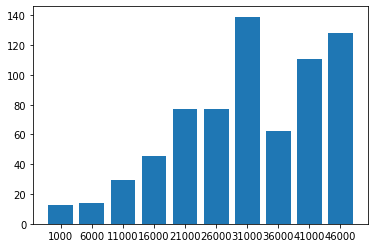

In [ ]:
# plot the results 
print(hypothesis_results)
x = list(hypothesis_results.keys())
y = list(hypothesis_results.values())

plt.bar(range(len(hypothesis_results)), y, tick_label=x)
plt.show()

# this is cumulated rewards against number of episodes that we are training the agent

Observation: cumulated rewards against number of episodes that we are training the agent.

Shows general upward trend but with a dip at 36000, again reflecting the randomness of the environment.

## B: The higher the min exploration rate... 

In [ ]:
import time

### 1. Mean cumulated rewards against exploration rate

In [ ]:
min_exploration_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
hypothesis_results = {}
hypothesis_time = {} 
for explore_rate in min_exploration_rates:
  start_time = time.time()
  q_table = train_agent(40000, min_explore_rate=explore_rate)
  hypothesis_time[f"{explore_rate}"] = time.time() - start_time
  episode_results = get_results(q_table) #get results for 100 episodes 
  hypothesis_results[f"{explore_rate}"] = episode_results.mean()


{'0.1': 42.58, '0.2': 88.36, '0.3': 182.54, '0.4': 321.42, '0.5': 311.65, '0.6': 316.76, '0.7': 362.19, '0.8': 405.57, '0.9': 402.9}


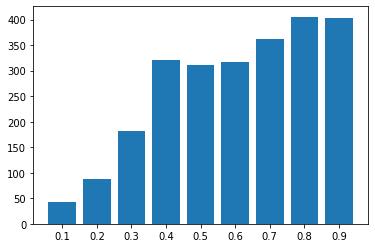

In [ ]:
# plot the results 
print(hypothesis_results)
x = list(hypothesis_results.keys())
y = list(hypothesis_results.values())

plt.bar(range(len(hypothesis_results)), y, tick_label=x)
plt.show()

Observation: mean cumulated rewards against min exploration rate, trained for 40000 episodes, and tested on 100 episodes. 

Shows upward trend, the cumulated rewards are likely to be higher if the agent explores more in a set number of episodes, which in this case is 40000. 

### 2. Average Time against Exploration Rate

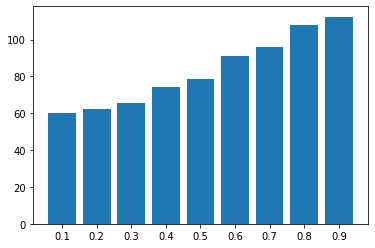

In [ ]:
# plot time results 

x = list(hypothesis_time.keys())
y = list(hypothesis_time.values())

plt.bar(range(len(hypothesis_time)), y, tick_label=x)
plt.show()

Observation: 
in general, the average time taken to complete one episode increases as the exploration rate increases. 


There is also a tradeoff between time taken to complete the learning for 40000 episodes and the cumulative rewards when testing. 

## C: The higher the min learning rate... 

In [ ]:
min_learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
hypothesis_results = {}
hypothesis_time = {} 
for learning_rate in min_learning_rates:
  start_time = time.time()
  q_table = train_agent(40000, min_learning_rate=learning_rate)
  hypothesis_time[f"{learning_rate}"] = time.time() - start_time
  episode_results = get_results(q_table)
  hypothesis_results[f"{learning_rate}"] = episode_results.mean()


### 1. Mean cumulated rewards against learning rate

{'0.1': 423.59, '0.2': 410.89, '0.3': 361.16, '0.4': 348.66, '0.5': 314.69, '0.6': 366.95, '0.7': 335.82, '0.8': 376.14, '0.9': 155.78}


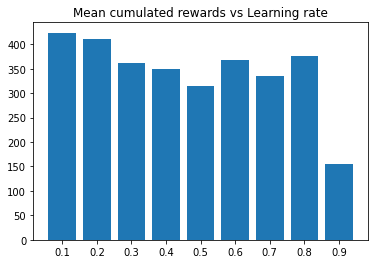

In [ ]:
# plot the results 
print(hypothesis_results)
x = list(hypothesis_results.keys())
y = list(hypothesis_results.values())
plt.title("Mean cumulated rewards vs Learning rate")
plt.bar(range(len(hypothesis_results)), y, tick_label=x)
plt.show()

Increasing the learning rate by too much, may decrease the accuracy of the agent. 

### 2. Average time per episode against Learning Rate

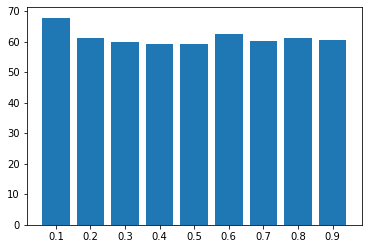

In [ ]:
# plot time results 

x = list(hypothesis_time.keys())
y = list(hypothesis_time.values())

plt.bar(range(len(hypothesis_time)), y, tick_label=x)
plt.show()

No particular trend for time. 

# Task 4b: How does Q_learning agent perform without Annealling?

## With Annealling 

In [ ]:
# training the agent 
start_time = time.time() 
q_value_table = np.zeros(no_buckets + (no_actions,)) 
for episode_no in range(50000):

  explore_rate = select_explore_rate(episode_no)
  learning_rate = select_learning_rate(episode_no)

  observation = env.reset() 
  start_state = bucketize_state_value(observation)
  prev_state = start_state 

  total_reward = 0 
  completed = False 
  while not completed:
    selected_action = select_action(prev_state, explore_rate)
    observation, reward_gain, completed, _ = env.step(selected_action)
    state_value = bucketize_state_value(observation)
    best_q_value =np.amax(q_value_table[state_value])
    q_value_table[prev_state + (selected_action,)] += learning_rate * (reward_gain + discount * best_q_value - q_value_table[prev_state + (selected_action, )]) # q learning equation 
    total_reward += reward_gain
    prev_state = state_value 

  if episode_no%2000==0:
      print("Episode: "+str(episode_no)+", Reward: "+ str(total_reward), ", Time: "+str(time.time()-start_time))


Episode: 0, Reward: 46.0 , Time: 0.011986255645751953
Episode: 2000, Reward: 9.0 , Time: 5.636455297470093
Episode: 4000, Reward: 12.0 , Time: 9.605300426483154
Episode: 6000, Reward: 14.0 , Time: 13.709104061126709
Episode: 8000, Reward: 12.0 , Time: 19.35977578163147
Episode: 10000, Reward: 15.0 , Time: 25.460246801376343
Episode: 12000, Reward: 22.0 , Time: 31.812737226486206
Episode: 14000, Reward: 23.0 , Time: 41.88807272911072
Episode: 16000, Reward: 45.0 , Time: 54.60723662376404
Episode: 18000, Reward: 25.0 , Time: 72.11561465263367
Episode: 20000, Reward: 96.0 , Time: 99.02816224098206
Episode: 22000, Reward: 45.0 , Time: 130.09304237365723
Episode: 24000, Reward: 56.0 , Time: 167.4773542881012
Episode: 26000, Reward: 417.0 , Time: 213.94988799095154
Episode: 28000, Reward: 27.0 , Time: 263.7466607093811
Episode: 30000, Reward: 47.0 , Time: 318.1780469417572
Episode: 32000, Reward: 33.0 , Time: 372.1923110485077
Episode: 34000, Reward: 188.0 , Time: 426.27114367485046
Episode:

## Without Annealling 

In [ ]:
# training the agent 
start_time = time.time() 
q_value_table = np.zeros(no_buckets + (no_actions,)) 
for episode_no in range(50000):

  explore_rate = min_explore_rate
  learning_rate = min_learning_rate

  observation = env.reset() 
  start_state = bucketize_state_value(observation)
  prev_state = start_state 

  total_reward = 0 
  completed = False 
  while not completed:
    selected_action = select_action(prev_state, explore_rate)
    observation, reward_gain, completed, _ = env.step(selected_action)
    state_value = bucketize_state_value(observation)
    best_q_value =np.amax(q_value_table[state_value])
    q_value_table[prev_state + (selected_action,)] += learning_rate * (reward_gain + discount * best_q_value - q_value_table[prev_state + (selected_action, )]) # q learning equation 
    total_reward += reward_gain
    prev_state = state_value 

  if episode_no%2000==0:
      print("Episode: "+str(episode_no)+", Reward: "+ str(total_reward), ", Time: "+str(time.time()-start_time))

Episode: 0, Reward: 11.0 , Time: 0.0034279823303222656
Episode: 2000, Reward: 13.0 , Time: 2.9623515605926514
Episode: 4000, Reward: 12.0 , Time: 8.536808490753174
Episode: 6000, Reward: 9.0 , Time: 15.421195030212402
Episode: 8000, Reward: 14.0 , Time: 25.285938024520874
Episode: 10000, Reward: 10.0 , Time: 31.67749333381653
Episode: 12000, Reward: 22.0 , Time: 39.53916621208191
Episode: 14000, Reward: 80.0 , Time: 52.292031049728394
Episode: 16000, Reward: 13.0 , Time: 69.17106461524963
Episode: 18000, Reward: 10.0 , Time: 98.09661364555359
Episode: 20000, Reward: 18.0 , Time: 122.29686212539673
Episode: 22000, Reward: 59.0 , Time: 154.48192167282104
Episode: 24000, Reward: 27.0 , Time: 191.81731295585632
Episode: 26000, Reward: 80.0 , Time: 240.17306327819824
Episode: 28000, Reward: 49.0 , Time: 291.8186070919037
Episode: 30000, Reward: 28.0 , Time: 343.73214888572693
Episode: 32000, Reward: 123.0 , Time: 392.2221369743347
Episode: 34000, Reward: 500.0 , Time: 446.3898012638092
Epis

As seen, Annealling helps to reduce the training time slightly, but again, it may depend on the situation due to the randomness of the environment. Therefore, we cannot draw strict conclusions just from one instance. 

## Are there other ways to reduce time taken for training?

1. Experience Replay Q-Learning updates are incremental and converge gradually. Multiple iterations of the Q-function are necessary for convergence. Utilizing an experience replay buffer would be beneficial. (Kumar, 2020)



# References
[1] S. Saito, Y. Wenzhuo, and R. Shanmugamani, Python reinforcement learning projects: Eight hands-on projects exploring reinforcement learning algorithms using tensorflow. Birmingham: Packt Publishing Ltd, 2018. 

[2] J. Brownlee, “Understand the impact of learning rate on neural network performance,” MachineLearningMastery.com, 11-Sep-2020. [Online]. Available: https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/. [Accessed: 25-Mar-2023]. 

[3] V. Lendave, “How to use learning rate annealing with neural networks?,” Analytics India Magazine, 27-Nov-2021. [Online]. Available: https://analyticsindiamag.com/how-to-use-learning-rate-annealing-with-neural-networks/#:~:text=into%20the%20picture.-,What%20is%20Learning%20Rate%20Annealing%3F,rates%20or%20learning%20rate%20annealing. [Accessed: 25-Mar-2023]. 


[4] Kumar, S. (2020, June 12). Balancing a cartpole system with reinforcement learning -- a tutorial. arXiv.org. Retrieved March 25, 2023, from https://arxiv.org/abs/2006.04938v2  [Retrieved March 25, 2023]

